In [25]:
"""
Imports pandas, numpy, re and datetime/time to the project
Returns the read csv file SAdf.csv
"""
import pandas as pd
import numpy as np
import re
from datetime import time

SAdf = pd.read_csv('SAdf.csv')

In [26]:
"""
Cleans and standardizes the 'Type' column in the DataFrame SAdf.
 
Args:
    SAdf (pd.DataFrame): The DataFrame containing the 'Type' column.

Returns:
    pd.DataFrame: The modified DataFrame.
"""

# Standardize the 'Type' column: convert to string, strip whitespace, and Title Case
SAdf['Type'] = SAdf['Type'].astype(str).str.strip().str.title()

# Define the list of allowed (canonical) values
canonical_types = ['Unprovoked', 'Provoked']

# Replace any value not in the canonical list with 'Unknown'
SAdf['Type'] = SAdf['Type'].mask(~SAdf['Type'].isin(canonical_types), 'Unknown')

SAdf
# Example of how you would call this function (assuming SAdf is defined):
# SAdf = clean_shark_attack_type(SAdf)

,Year,Date,Time,Type,Sex,Age,Activity,Location,Country,State,Fatal Y/N
0,2025,29th September,0100hrs,Unprovoked,M,54,Swimming,Catalina Island,USA,Off California,N
1,2025,1st September,1524hrs,Unprovoked,M,8,Snorkeling,Horseshoe reef Key Largo,USA,Florida,N
2,2025,30th August,Not stated,Unprovoked,F,8,Swimming,Galveston,USA,Texas,N
3,2025,16th August,1055 hrs,Provoked,M,?,Fishing,Cayo Costa Boca Grande,USA,Florida,N
4,2025,19th July,Not stated,Unprovoked,M,69,Diving,Jupiter Inlet off Jupiter Beach Palm Beach County,USA,Florida,N
...,...,...,...,...,...,...,...,...,...,...,...
815,2010,28-Apr-2010,Afternoon,Provoked,M,29,Measuring sharks,Hanalei Bay,USA,Florida,N
816,2010,19-Apr-2010,16h00,Unprovoked,M,68,Surfing,"Hanalei Bay, Kauai",USA,Hawaii,N
817,2010,06-Feb-2010,15h00,Provoked,M,NaN,Surf fishing / wading,Riviera Beach,USA,Florida,N
818,2010,03-Feb-2010,15h44,Unprovoked,M,38,Kite Boarding,"Stuart, Martin County",USA,Florida,Y


In [27]:
"""
Performs multi-step cleaning and standardization on the 'Time' column of the DataFrame.
 
The process involves:
1. Creating a temporary column ('Time_Cleaned').
2. Using regex to standardize various formats (xxhxx, xxxxhrs, decimal) into 'HH:MM'.
3. Filtering out descriptive/range values and setting them to NaN.
4. Coercing the standardized strings into datetime.time objects in the original 'Time' column.

Args:
    SAdf (pd.DataFrame): The DataFrame containing the 'Time' column.

Returns:
    pd.DataFrame: The modified DataFrame with the cleaned 'Time' column and 
                  without the temporary 'Time_Cleaned' column.
"""

# 1. Removing white spaces and ensuring string type
# Create the temporary column 'Time_Cleaned' directly from the string version of 'Time'.
SAdf['Time_Cleaned'] = SAdf['Time'].fillna('').astype(str).apply(str.strip)

# 2. Step 1: Standardize Common Patterns using Regex 

# Pattern 1: xxhxx (e.g., '12h30', '9h0')
SAdf['Time_Cleaned'] = SAdf['Time_Cleaned'].str.replace(
    r'^(\d{1,2})h(\d{0,2})$',
    lambda m: f"{int(m.group(1)):02d}:{m.group(2).zfill(2)}", # Format to 09:00, 13:15
    regex=True
)

# Pattern 2 & 3: Consolidated xxxxhrs/hr OR numeric-only time (e.g., '0100hrs', '1524', '100hrs')
def military_time_formatter(match):
    # m.group(1) is the digits (e.g., '100' or '1524')
    digits = match.group(1)
    
    # 1. Pad to 4 digits (e.g., '100' -> '0100')
    padded_digits = digits.zfill(4)
    
    # 2. Extract HH and MM and join with a colon (e.g., '0100' -> '01:00')
    return f"{padded_digits[:2]}:{padded_digits[-2:]}"

# Combine matching for xxxxhrs (Pattern 2)
SAdf['Time_Cleaned'] = SAdf['Time_Cleaned'].str.replace(
    r'^(\d{3,4})\s*hrs?$', 
    military_time_formatter,
    regex=True
)

# Combine matching for xxxx (Pattern 3)
SAdf['Time_Cleaned'] = SAdf['Time_Cleaned'].str.replace(
    r'^(?!\d{1,2}h)(\d{3,4})$', # Numeric only, not already matched by xxhxx
    military_time_formatter,
    regex=True
)

# Pattern 4: decimal time (e.g., '15.5')
def convert_decimal(match):
    hour = int(match.group(1))
    # m.group(2) is the decimal part (e.g., '5')
    # We need to calculate minutes from the decimal part (e.g., 0.5 * 60 = 30)
    minute = int(round(float(f"0.{match.group(2)}")) * 60)
    # Ensure hour padding here as well
    return f"{hour:02d}:{minute:02d}"

SAdf['Time_Cleaned'] = SAdf['Time_Cleaned'].str.replace(
    r'^(\d{1,2})\.(\d{1,2})$', 
    convert_decimal, 
    regex=True
)

# 3. Step 2: Handle Ranges, Descriptions, and Unknowns 

# Values that are ranges, descriptive, or malformed should be set to NaN (missing)
descriptive_or_range_values = [
    'Not stated', 'AM', '?', 'after 1200hr', '14h00-15h00', '14h00  -15h00',
    'Late afternoon', '14h30 / 15h30', 'Morning ', '09h30 / 10h00',
    '10h45-11', 'Night', 'Afternoon', 'Early Morning', 'Evening', 
    'Lunchtime', 'Unknown', '' # Added common descriptive/empty values to the list
]

# Replace values that match the list with NaN
SAdf['Time_Cleaned'] = SAdf['Time_Cleaned'].replace(descriptive_or_range_values, np.nan)

# 4. Step 3: Convert the cleaned string time to a datetime.time object
# This step will convert the 'HH:MM' string to a proper time object, leaving NaNs as NaNs.
def string_to_time(time_str):
    if pd.isna(time_str):
        return np.nan
    try:
        # Use pandas to_datetime and extract the time part
        return pd.to_datetime(time_str, format='%H:%M', errors='coerce').time()
    except Exception:
        # Catch any remaining malformed strings
        return np.nan

SAdf['Time'] = SAdf['Time_Cleaned'].apply(string_to_time)

# 5. Drop the temporary column
SAdf = SAdf.drop(columns=['Time_Cleaned'])

SAdf

,Year,Date,Time,Type,Sex,Age,Activity,Location,Country,State,Fatal Y/N
0,2025,29th September,01:00:00,Unprovoked,M,54,Swimming,Catalina Island,USA,Off California,N
1,2025,1st September,15:24:00,Unprovoked,M,8,Snorkeling,Horseshoe reef Key Largo,USA,Florida,N
2,2025,30th August,NaN,Unprovoked,F,8,Swimming,Galveston,USA,Texas,N
3,2025,16th August,10:55:00,Provoked,M,?,Fishing,Cayo Costa Boca Grande,USA,Florida,N
4,2025,19th July,NaN,Unprovoked,M,69,Diving,Jupiter Inlet off Jupiter Beach Palm Beach County,USA,Florida,N
...,...,...,...,...,...,...,...,...,...,...,...
815,2010,28-Apr-2010,NaN,Provoked,M,29,Measuring sharks,Hanalei Bay,USA,Florida,N
816,2010,19-Apr-2010,16:00:00,Unprovoked,M,68,Surfing,"Hanalei Bay, Kauai",USA,Hawaii,N
817,2010,06-Feb-2010,15:00:00,Provoked,M,NaN,Surf fishing / wading,Riviera Beach,USA,Florida,N
818,2010,03-Feb-2010,15:44:00,Unprovoked,M,38,Kite Boarding,"Stuart, Martin County",USA,Florida,Y


In [28]:
"""
Creates a 'Time_Range' column based on the hour extracted from the 'Time' column.
NaN values resulting from missing 'Time' data are renamed to 'Unknown'.

Args:
    SAdf (pd.DataFrame): The DataFrame containing the 'Time' column (expected 
                          to contain datetime.time objects or pandas.NaT).

Returns:
    pd.DataFrame: The modified DataFrame with the new 'Time_Range' column.
"""


def categorize_time(time_obj):
    """
    Categorizes a datetime.time object into a descriptive time range.
    """
    # If the time is NaT (missing or invalid), return NaN
    if pd.isna(time_obj):
        return np.nan
    
    # Extract the hour component (0-23)
    hour = time_obj.hour

    if 6 <= hour < 12:
        return 'Morning'         # 06:00:00 to 11:59:59
    elif 12 <= hour < 17:
        return 'Afternoon'       # 12:00:00 to 16:59:59 (Noon to 5 PM)
    elif 17 <= hour < 22:
        return 'Evening'         # 17:00:00 to 21:59:59 (5 PM to 10 PM)
    else: # 22 <= hour <= 23 OR 0 <= hour < 6
        return 'Night'           # 22:00:00 to 05:59:59 (10 PM to 6 AM)

# Apply the categorization function to the cleaned 'Time' column
SAdf['Time_Range'] = SAdf['Time'].apply(categorize_time)

# Replace NaN values with 'Unknown'
SAdf['Time_Range'] = SAdf['Time_Range'].fillna('Unknown')
    
SAdf

# Example of how you would call this function (assuming SAdf is defined):
# SAdf = create_time_range_column(SAdf)

,Year,Date,Time,Type,Sex,Age,Activity,Location,Country,State,Fatal Y/N,Time_Range
0,2025,29th September,01:00:00,Unprovoked,M,54,Swimming,Catalina Island,USA,Off California,N,Night
1,2025,1st September,15:24:00,Unprovoked,M,8,Snorkeling,Horseshoe reef Key Largo,USA,Florida,N,Afternoon
2,2025,30th August,NaN,Unprovoked,F,8,Swimming,Galveston,USA,Texas,N,Unknown
3,2025,16th August,10:55:00,Provoked,M,?,Fishing,Cayo Costa Boca Grande,USA,Florida,N,Morning
4,2025,19th July,NaN,Unprovoked,M,69,Diving,Jupiter Inlet off Jupiter Beach Palm Beach County,USA,Florida,N,Unknown
...,...,...,...,...,...,...,...,...,...,...,...,...
815,2010,28-Apr-2010,NaN,Provoked,M,29,Measuring sharks,Hanalei Bay,USA,Florida,N,Unknown
816,2010,19-Apr-2010,16:00:00,Unprovoked,M,68,Surfing,"Hanalei Bay, Kauai",USA,Hawaii,N,Afternoon
817,2010,06-Feb-2010,15:00:00,Provoked,M,NaN,Surf fishing / wading,Riviera Beach,USA,Florida,N,Afternoon
818,2010,03-Feb-2010,15:44:00,Unprovoked,M,38,Kite Boarding,"Stuart, Martin County",USA,Florida,Y,Afternoon


In [29]:
"""
Counts shark attacks by 'Time_Range' and calculates the percentage for 
each known time category, excluding 'Unknown' incidents from the total 
used for the percentage calculation.

Args:
    SAdf (pd.DataFrame): The DataFrame containing the 'Time_Range' column.

Returns:
    pd.DataFrame: A DataFrame with 'Time Range', 'Incident Count', and 
                  'Percentage' columns.
"""
 
# 1. Calculate the count of shark attacks per time range category (including 'Unknown').
attacks_by_time_range = SAdf['Time_Range'].value_counts(dropna=False)

# 2. Convert the Series to a DataFrame and rename the count column
attacks_df = attacks_by_time_range.reset_index()
attacks_df.columns = ['Time Range', 'Incident Count']

# 3. Calculate total incidents FOR KNOWN TIMES ONLY
# Filter out 'Unknown' and count the remainder.
total_incidents_known = SAdf[SAdf['Time_Range'] != 'Unknown']['Time_Range'].count()

# 4. Create the new column for the percentage.
# The percentage is calculated relative to total_incidents_known.
# The 'Unknown' row itself is assigned 0% to reflect that it's an un-categorized incident.
attacks_df['Percentage'] = attacks_df.apply(
    lambda row: (row['Incident Count'] / total_incidents_known) * 100
    if row['Time Range'] != 'Unknown'
    else 0,
    axis=1
)

# 5. Format the percentage to two decimal places for readability
attacks_df['Percentage'] = attacks_df['Percentage'].round(2).astype(str) + '%'
 
attacks_df

# Example of how you would call this function (assuming SAdf is defined):
# time_breakdown_df = calculate_time_range_percentage(SAdf)

,Time Range,Incident Count,Percentage
0,Afternoon,300,52.17%
1,Unknown,245,0.0%
2,Morning,190,33.04%
3,Evening,78,13.57%
4,Night,7,1.22%


In [30]:
"""
Groups shark attack incidents by 'Time_Range' and 'Type', counts the incidents
in each group, and calculates the percentage of the total known time incidents.

NOTE: The current code relies on the previous step where NaN in 'Time_Range' 
was replaced with 'Unknown'. Therefore, filtering 'Time_Range'.notna() will 
exclude all incidents categorized as 'Unknown'.

Args:
    SAdf (pd.DataFrame): The DataFrame containing the 'Time_Range' and 'Type' columns.

Returns:
    pd.DataFrame: A DataFrame showing the 'Time_Range', 'Type', 'Incident Count', 
                  and 'Percentage' for all categorized time incidents.
"""
 
# 1. Filter the DataFrame to include only incidents with a known time range
# Assuming 'Unknown' is the category to exclude (as it's the old NaN).
known_time_incidents = SAdf[SAdf['Time_Range'] != 'Unknown'].copy()

# 2. Calculate the total number of known incidents (denominator for percentage)
total_known_incidents = len(known_time_incidents)

# 3. Group by Time_Range and Type, then count the size of each group
grouped_incidents = known_time_incidents.groupby(['Time_Range', 'Type']).size().reset_index(name='Incident Count')

# 4. Calculate the percentage of the total known incidents
grouped_incidents['Percentage'] = (grouped_incidents['Incident Count'] / total_known_incidents) * 100

# 5. Format the percentage column for clean display
grouped_incidents['Percentage'] = grouped_incidents['Percentage'].round(2).astype(str) + '%'
 
grouped_incidents

# Example of how you would call this function (assuming SAdf is defined):
# attack_breakdown = analyze_time_range_and_attack_type(SAdf)

,Time_Range,Type,Incident Count,Percentage
0,Afternoon,Provoked,16,2.78%
1,Afternoon,Unknown,22,3.83%
2,Afternoon,Unprovoked,262,45.57%
3,Evening,Provoked,4,0.7%
4,Evening,Unknown,12,2.09%
5,Evening,Unprovoked,62,10.78%
6,Morning,Provoked,7,1.22%
7,Morning,Unknown,18,3.13%
8,Morning,Unprovoked,165,28.7%
9,Night,Provoked,2,0.35%


In [63]:
SAdf.Sex.unique()

SAdf['Sex']=SAdf.Sex.fillna('UNKNOWN')

SAdf.Sex.isna().sum()

SAdf['Sex'] = (SAdf['Sex'].astype(str).str.strip().str.upper())

SAdf.Sex.unique()

SAdf.Sex.value_counts()

Sex
M    599
Y    221
Name: count, dtype: int64

In [64]:
def clean_age(x):
    if pd.isna(x):
        return np.nan
    x = str(x).strip().lower()
    if x in ['?','!!']:
        return np.nan
    if x.isdigit():
        return int(x)
    if re.match(r'^\d{2}s$', x):
        return int(x[:2])
    if 'teen' in x:
        return 15
    if 'middle' in x:
        return 45
    if 'minor' in x:
        return 10
        
    nums = re.findall(r'\d+', x)
    if len(nums) >= 1:
        return int(nums[0])

    return np.nan



In [65]:
SAdf['Age'] = SAdf['Age'].apply(clean_age).astype('Int32')


In [66]:
SAdf['Age'].unique()

<IntegerArray>
[  54,    8, <NA>,   69,   18,   21,   40,   20,   12,    9,   42,   26,   23,
   27,   16,   14,   45,   49,   25,   15,   46,   19,   65,   11,   39,   66,
   30,   50,   52,   38,   37,   22,   60,   47,    2,   35,   24,   13,   58,
   67,   34,   68,   43,   10,   29,   51,   31,   33,   41,   17,   28,   62,
   56,    6,   64,   36,    7,   71,   57,   73,   61,   48,   70,   55,   63,
   32,   74,    3,   59,   44,   53,    5,   86]
Length: 73, dtype: Int32

In [67]:
SAdf['Activity'] = SAdf['Activity'].str.lower().str.strip()

In [68]:
activity_map = {
    'surf': 'Surfing',
    'kite': 'Surfing',
    'body surf': 'Surfing',

    'swim': 'Swimming',
    'treading water': 'Swimming',

    'diving': 'Diving',
    'scuba': 'Diving',
    'snorkel': 'Diving',

    'fish': 'Fishing',
    'spear': 'Fishing',
    'lobster': 'Fishing',

    'paddle': 'Paddleboarding',
    'canoe': 'Paddleboarding',
    'kayak': 'Paddleboarding',

    'wading': 'Wading/Standing',
    'standing': 'Wading/Standing',
    'walking': 'Wading/Standing',

    'touching a shark': 'Animal Interaction',
    'feeding': 'Animal Interaction',

    'photo': 'Photography',
    'filming': 'Photography',

    'unknown': 'Unknown',
    'not stated': 'Unknown',
    'undisclosed': 'Unknown'
}

In [69]:
def map_activity(x):
    if pd.isna(x):
        return 'Unknown'
    x = str(x).lower()

    for key, value in activity_map.items():
        if key in x:
            return value
    return 'Other'

In [61]:
SAdf['Activity'] = SAdf['Activity'].apply(map_activity)

In [62]:
SAdf['Activity'].unique()

array(['Swimming', 'Diving', 'Fishing', 'Surfing', 'Unknown',
       'Wading/Standing', 'Other', 'Photography', 'Animal Interaction',
       'Paddleboarding'], dtype=object)

In [32]:
def extract_county(location_string):
    """
    Attempts to extract the County name from a location string
    and ensures the result is always formatted as 'CountyName County'.
    """
    location = str(location_string).strip()
    
    # 1. Standard Pattern Check
    # Look for text preceding ' County' and capture ONLY the county name.
    match = re.search(r'([A-Za-z\s]+)\sCounty', location, re.IGNORECASE)
    if match:
        # Returns: 'Volusia County'
        return match.group(1).strip() + ' County'

    # 2. Handle Specific Common Cases
    # For these manual cases, we append ' County' directly.
    if 'Myrtle Beach' in location or 'North Myrtle Beach' in location:
        return 'Horry County'
    if 'Galveston' == location:
        return 'Galveston County'
    if 'New Smyrna Beach' == location:
        return 'Volusia County'
    if 'Kauai' in location:
        return 'Kauai County'
    if 'Maui' in location:
        return 'Maui County'
    if 'Oahu' in location or 'Haleiwa' in location:
        return 'Oahu County'
    if 'Miami Beach' in location or 'Miami' == location:
        return 'Miami-Dade County'
    if 'South Padre Island' in location:
        return 'Cameron County'
    
    # 3. Handle specific existing counties that don't need ' County' appended
    # (e.g., if you know 'Miami-Dade' is often in the data and you don't want 'Miami-Dade County County')
    if 'Miami-Dade' in location:
        return 'Miami-Dade County'

    # If no county is definitively found, return the full location for manual review
    # (These will be the entries that couldn't be grouped)
    return location


SAdf['Location'] = SAdf['Location'].apply(extract_county)
#SAdf=SAdf[SAdfSAdf['Location']>0].index
#SAdf['Location']=SAdf.Location.fillna('UNKNOWN')
#SAdf_Location=SAdf[SAdf["Location"].isin(SA_HighOccurences)]

#SALreplacements= {"New Smyrna Beach": "New Smyrna Beach, Volusia County"}
#SAdf_activitySAdf_activity.replace(SAAreplacements)
#SAdf_Location['Location'].nunique()

SAdf['Fatal Y/N'] = SAdf['Fatal Y/N'].str.strip()
SAdf_Fatal_replacements={
    'F':'Y',
    'Nq':'N',
    'n':'N',
    'UNKNOWN':'Y'
}
SAdf.replace(SAdf_Fatal_replacements, inplace=True)
SAdf=SAdf.rename(columns={ "Fatal (Y/N)": "Fatal"})

SAdf['State'] = SAdf['State'].str.strip()
SAdf_Fatal_replacements={
    'Floria':'Florida',
    'BAHAMAS':'Bahamas',
}
SAdf.replace(SAdf_Fatal_replacements, inplace=True)

In [33]:
SAdf['Age'] = SAdf['Age'].astype('Int32')

In [34]:
SAdf.nunique()

Year                 17
Date                697
Time                151
Type                  3
Sex                   2
Age                  72
Activity            112
Location            229
Country               1
State                35
Fatal Y/N             2
Time_Range            5
Activity_clean       99
Activity_grouped     10
dtype: int64

In [35]:
SAdf['Location'].value_counts()

Location
Volusia County                                     117
Brevard County                                      58
Maui County                                         41
Monroe County                                       27
Palm Beach County                                   25
                                                  ... 
Talofofo Bay                                         1
Grand Cayman                                         1
Napoopoo Park in Kealakekua Bay, The Big Island      1
Off Key Biscayne                                     1
Elliot Key                                           1
Name: count, Length: 229, dtype: int64

In [12]:
SAdf

,Year,Date,Time,Type,Sex,Age,Activity,Location,Country,State,Fatal Y/N,Time_Range,Activity_clean,Activity_grouped
0,2025,29th September,01:00:00,Unprovoked,M,54,Swimming,Catalina Island,USA,Off California,N,Night,swimming,Swimming
1,2025,1st September,15:24:00,Unprovoked,M,8,Snorkeling,Horseshoe reef Key Largo,USA,Florida,N,Afternoon,snorkeling,Diving
2,2025,30th August,NaN,Unprovoked,Y,8,Swimming,Galveston County,USA,Texas,N,Unknown,swimming,Swimming
3,2025,16th August,10:55:00,Provoked,M,<NA>,Fishing,Cayo Costa Boca Grande,USA,Florida,N,Morning,fishing,Fishing
4,2025,19th July,NaN,Unprovoked,M,69,Diving,Jupiter Inlet off Jupiter Beach Palm Beach County,USA,Florida,N,Unknown,diving,Diving
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
815,2010,28-Apr-2010,NaN,Provoked,M,29,Measuring sharks,Hanalei Bay,USA,Florida,N,Unknown,measuring sharks,Other
816,2010,19-Apr-2010,16:00:00,Unprovoked,M,68,Surfing,Kauai County,USA,Hawaii,N,Afternoon,surfing,Surfing
817,2010,06-Feb-2010,15:00:00,Provoked,M,<NA>,Surf fishing / wading,Riviera Beach,USA,Florida,N,Afternoon,surf fishing / wading,Surfing
818,2010,03-Feb-2010,15:44:00,Unprovoked,M,38,Kite Boarding,Martin County,USA,Florida,Y,Afternoon,kite boarding,Surfing


In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

In [18]:
# 1. Parse to datetime
SAdf['Date'] = pd.to_datetime(SAdf['Date'], errors='coerce')

# 2. Drop rows with invalid date (must use inplace=True OR reassign)
SAdf = SAdf.dropna(subset=['Date']).copy()  
# 3. Extract month as integer
SAdf.loc[:, 'Month'] = SAdf['Date'].dt.month.astype(int)

/var/folders/tj/ks1sq5t50v5465wqpwwb64b00000gn/T/ipykernel_18335/1383002058.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=month_counts.index, y=month_counts.values, palette="Blues_d")


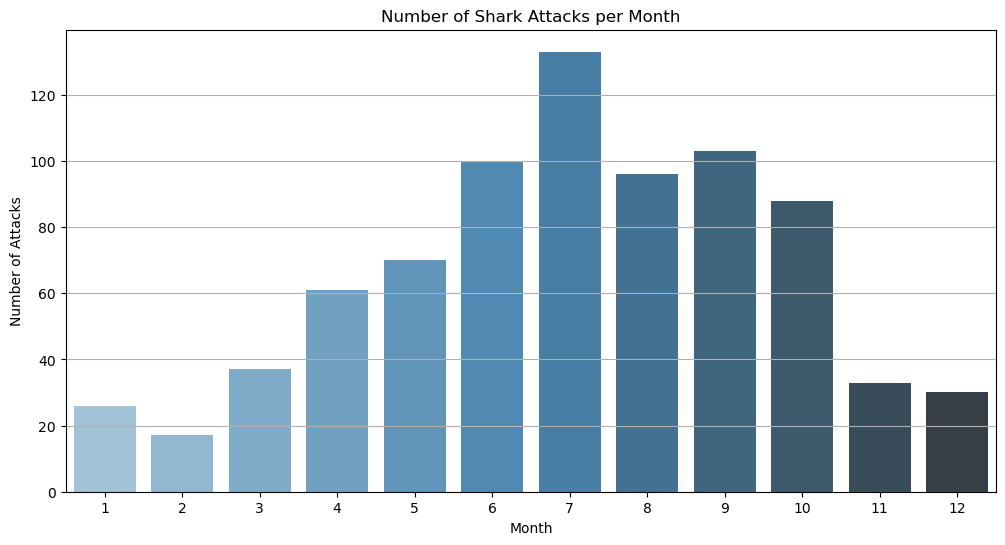

In [20]:
plt.figure(figsize=(12,6))

sns.barplot(x=month_counts.index, y=month_counts.values, palette="Blues_d")

plt.title("Number of Shark Attacks per Month")
plt.xlabel("Month")
plt.ylabel("Number of Attacks")
plt.grid(axis='y')

plt.savefig("shark_attacks_per_month.png", dpi=300, bbox_inches='tight')

plt.show()

In [41]:
SAdf['Type'].value_counts()

Type
Unprovoked    681
Unknown        84
Provoked       55
Name: count, dtype: int64

In [48]:
SAdf['Activity'].unique()

array(['swimming', 'snorkeling', 'fishing', 'diving', 'surfing',
       'undisclosed', 'diving into water', 'wading',
       'playing football in the water',
       'unconfirmed possibly swimming near the boat harbour',
       'swimming ocean training', 'spearfishing', 'kayak fishing',
       'boogie boarding', 'sitting', 'standing', 'filming',
       'shark feeding', 'windsurfing', 'kite-surfing', 'spearishing',
       'shipwreck', 'swimming  or snorkeling', 'paddleboarding',
       'lobstering', nan, 'lifeguard training exercise',
       'lifeguard exercises', 'scalloping', 'jumped into water',
       'feeding sharks & stingrays', 'kayaking', 'wing foil surfing',
       'fishing, fell in water', 'playing', 'canoeing', 'kite foiling',
       'boggie boarding', 'tagging sharks', 'body surfing',
       'surf fishing', 'treading water', 'skimboarding', 'body boarding',
       'stand-up paddleboarding', 'stand-up paddle boarding',
       'swimming/ treading water', 'spearfishing / diving'

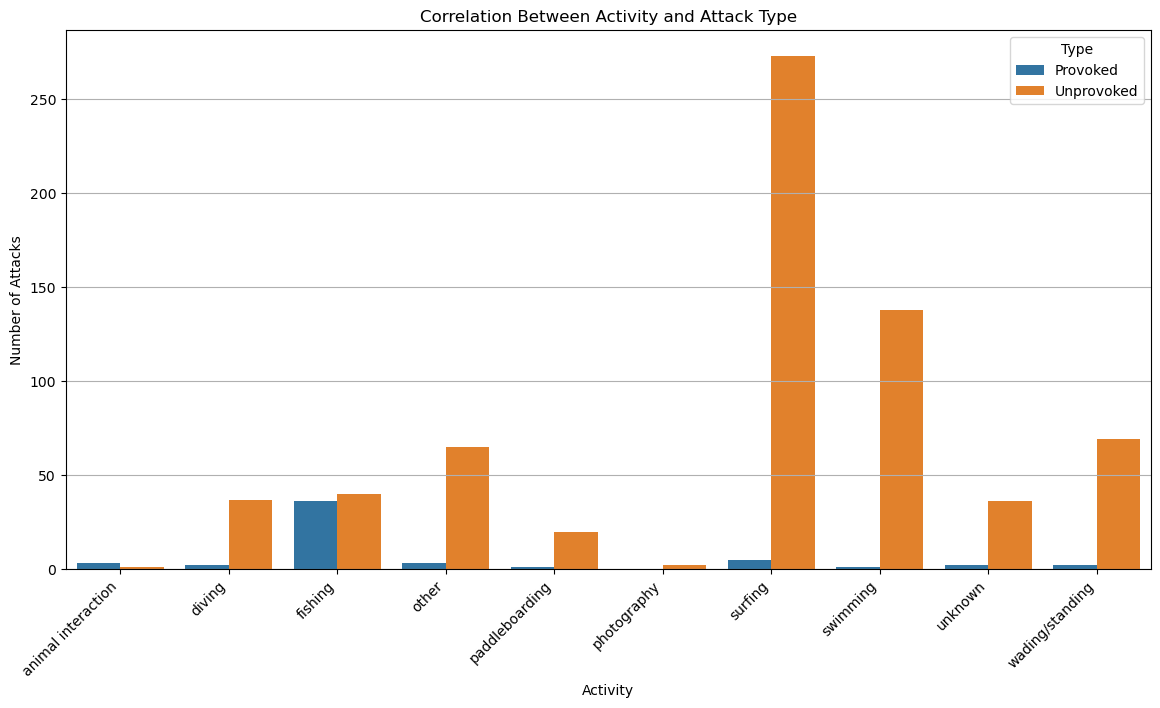

In [70]:
# --- 1. Keep only Provoked / Unprovoked ---
df2 = SAdf[SAdf['Type'].isin(['Provoked', 'Unprovoked'])]

# --- 2. Count activity × type ---
activity_type = df2.groupby(['Activity', 'Type']).size().reset_index(name='Count')

# --- 3. Plot grouped bar chart ---
plt.figure(figsize=(14,7))
sns.barplot(data=activity_type, x='Activity', y='Count', hue='Type')

plt.title("Correlation Between Activity and Attack Type")
plt.xlabel("Activity")
plt.ylabel("Number of Attacks")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')

plt.savefig("activity_vs_type.png", dpi=300, bbox_inches='tight')
plt.show()